# Frequentist Machine Learning Data Exploration
## Joseph Bentivegna
## Sam Keene

This project explores two datasets.  The first is a time series of gas prices throughout New York State, and the second is a time series of the price of the S&P 500. I begin the analysis by observing the relationship between the different gas prices and then plot it against the S&P 500. Finally, I use Facebook's Prophet API to predict the future of NYC gas prices.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [2]:
# read in CSV data
gas_data = pd.read_csv("gas_data.csv", index_col='Date')
sp_data = pd.read_csv("sp_data.csv", index_col='Date')

In [3]:
# preprocess data
gas_data.columns = ['ny state', 'albany', 'binghamton', 'buffalo', 'nassau', 'nyc', 'rochester', 'syracuse', 'utica']

gas_data.index = pd.to_datetime(gas_data.index)
sp_data.index = pd.to_datetime(sp_data.index)

gas_data = gas_data.sort_index(ascending=False)
sp_data = sp_data.sort_index(ascending=False)

sp_data = sp_data[sp_data.index.isin(gas_data.index)]
gas_data = gas_data[gas_data.index.isin(sp_data.index)]

## Below I print out the shape of the datasets and a small snipet from the beginning of each.  I like to print these out to observe what my data looks like and to make sure that none of my preprocessing steps messed anything up.

In [4]:
print (gas_data.shape)
gas_data.head()

(558, 9)


,ny state,albany,binghamton,buffalo,nassau,nyc,rochester,syracuse,utica
Date,,,,,,,,,
2018-07-30,3.00,2.88,2.92,3.0,3.00,3.10,2.95,2.90,2.96
2018-07-23,3.01,2.89,2.93,3.0,3.01,3.10,2.95,2.91,2.97
2018-07-16,3.02,2.91,2.95,3.0,3.03,3.11,2.97,2.92,2.98
2018-07-09,3.02,2.92,2.97,3.0,3.03,3.12,2.98,2.92,2.98
2018-07-02,3.02,2.92,2.94,3.0,3.02,3.11,2.96,2.90,2.98


In [5]:
print (sp_data.shape)
sp_data.head()

(558, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-30,2819.000000,2840.379883,2796.340088,2840.350098,2840.350098,17132630000
2018-07-23,2799.169922,2848.030029,2795.139893,2818.820068,2818.820068,16947010000
2018-07-16,2797.360107,2816.760010,2789.239990,2801.830078,2801.830078,15449650000
2018-07-09,2775.620117,2804.530029,2770.729980,2801.310059,2801.310059,14514320000
2018-07-02,2704.949951,2764.409912,2698.949951,2759.820068,2759.820068,10493320000


In [6]:
# resample data to smooth it
filt_gas_data = gas_data.resample('m').mean()
filt_sp_data = sp_data.resample('m').mean()

## This first plot shows the gas prices for different New York counties from 2008 to 2018.  The NY State average is also listed.

## Note that the gas prices are highly correlated (as expected) but that New York City is almost always higher than the rest

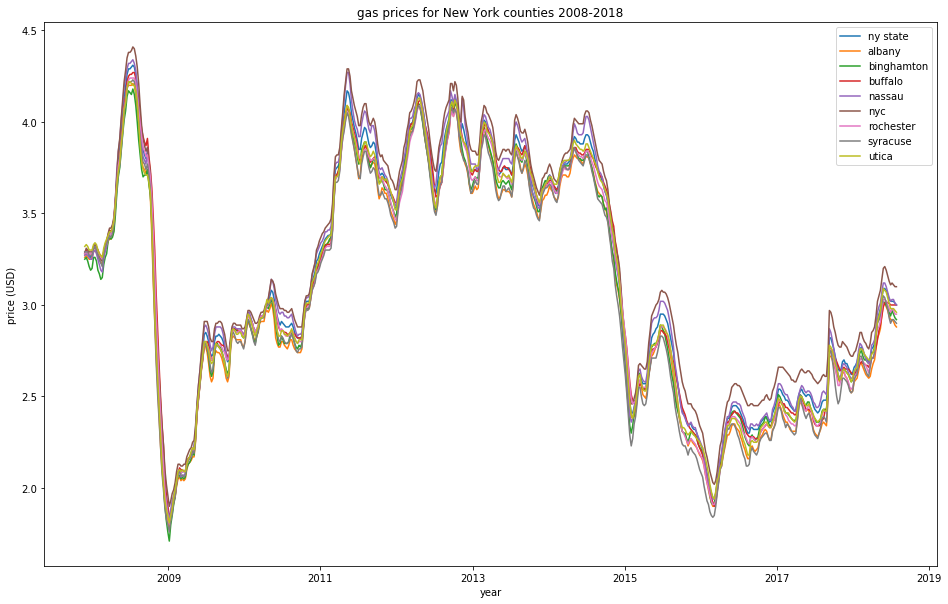

In [7]:
fig, ax = plt.subplots(figsize=[16,10])

for ii in gas_data.columns:
    ax.plot(gas_data.index, gas_data[ii], label=str(ii))

ax.set(xlabel='year', ylabel='price (USD)') 
ax.set_title('gas prices for New York counties 2008-2018')
plt.legend()
plt.show()

## Since the last plot was very zoomed out I wanted to get a closer look of what gas prices looked like in recent months.  Below is the plot of gas prices for all the counties since August 2017.

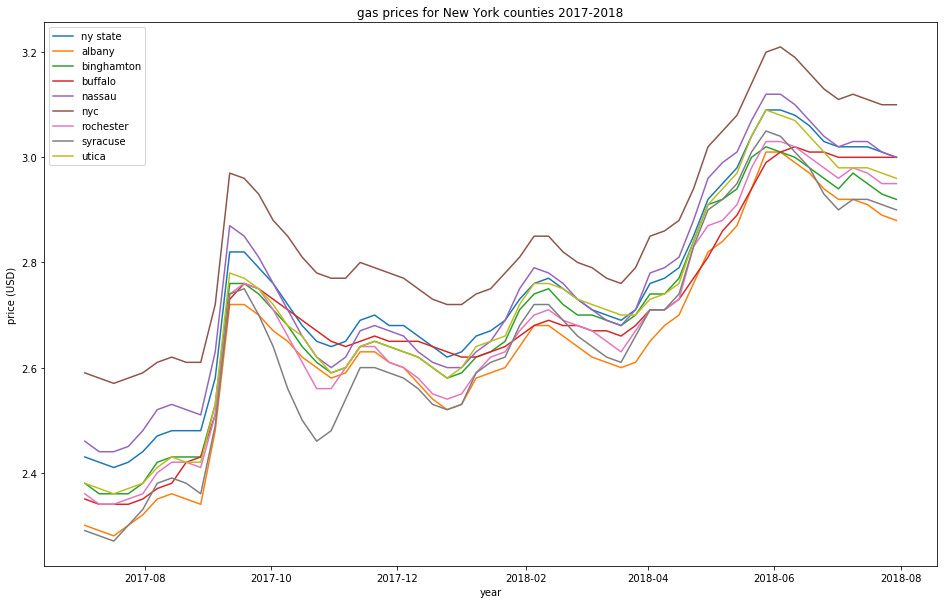

In [8]:
fig, ax = plt.subplots(figsize=[16,10])

for ii in gas_data.columns:
    slice_gas = gas_data[:'2017-07']
    ax.plot(slice_gas.index, slice_gas[ii], label=str(ii))

ax.set(xlabel='year', ylabel='price (USD)') 
ax.set_title('gas prices for New York counties 2017-2018')
plt.legend()
plt.show()

## I began to wonder what played a role in the price of gas in New York.  I hypothesized that it would be highly correlated with the S&P 500 stock price.  Below is the same plot as the first one, but with the S&P 500 open price plotted on the dual axis.

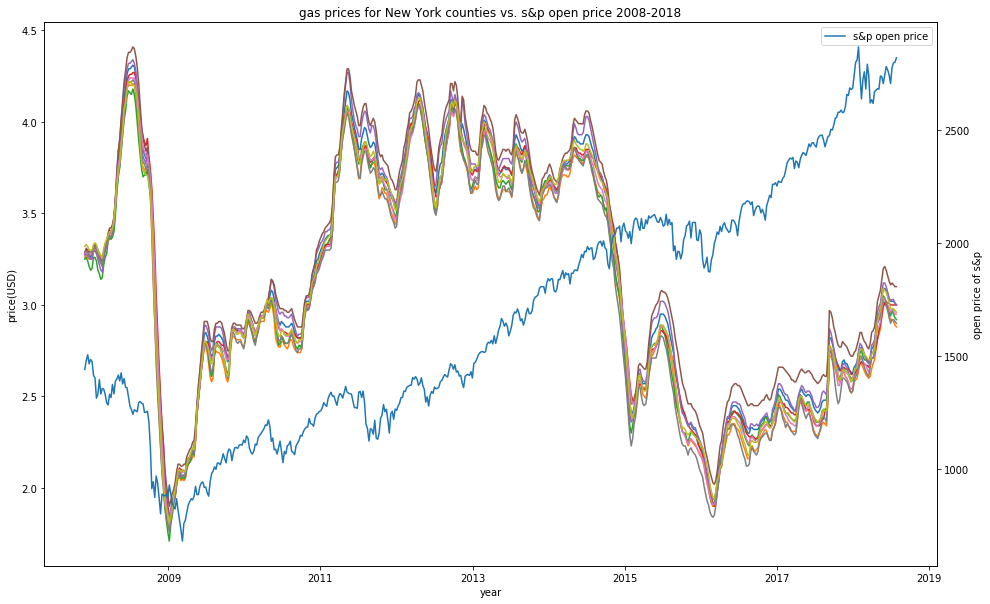

In [9]:
fig, ax = plt.subplots(figsize=[16,10])

for ii in gas_data.columns:
    ax.plot(gas_data.index, gas_data[ii], label=str(ii))
    
ax1 = ax.twinx()
ax1.plot(sp_data.index, sp_data['Open'], label='s&p open price')

ax.set(xlabel='year', ylabel='price(USD)') 
ax1.set_ylabel('open price of s&p')
ax.set_title('gas prices for New York counties vs. s&p open price 2008-2018')
plt.legend()
plt.show()

## As seen above, I was wrong... gas prices are not that correlated with US markets. I wanted to see if things changed when I zoomed in. 

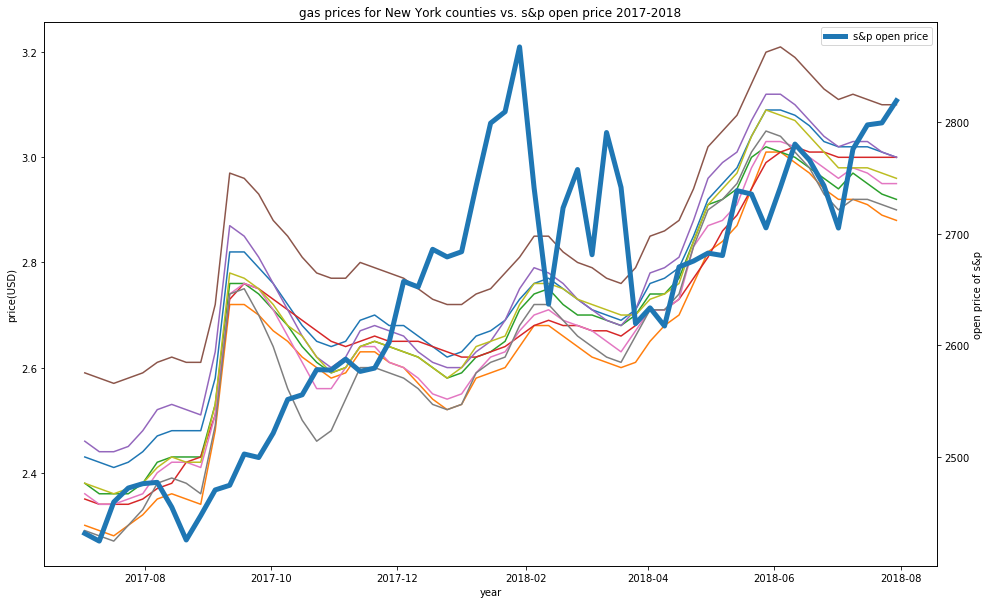

In [10]:
fig, ax = plt.subplots(figsize=[16,10])

for ii in gas_data.columns:
    slice_gas = gas_data[:'2017-07']
    ax.plot(slice_gas.index, slice_gas[ii], label=str(ii))

ax1 = ax.twinx()
slice_sp = sp_data[:'2017-07']
ax1.plot(slice_sp.index,slice_sp['Open'], label='s&p open price', linewidth=5.0)    
    
ax.set(xlabel='year', ylabel='price(USD)') 
ax1.set_ylabel('open price of s&p')
ax.set_title('gas prices for New York counties vs. s&p open price 2017-2018')
plt.legend()
plt.show()

In [11]:
corr = slice_gas['ny state'].corr(slice_sp['Open'])
print (corr)

0.679949229471


## While it appears that the overall trend is a bit more related, a quick correlation calculation proves that the zoomed in correlation is still quite low.  

## The next analysis I wanted to do was observe how New York City gas prices diverge from New York State average prices

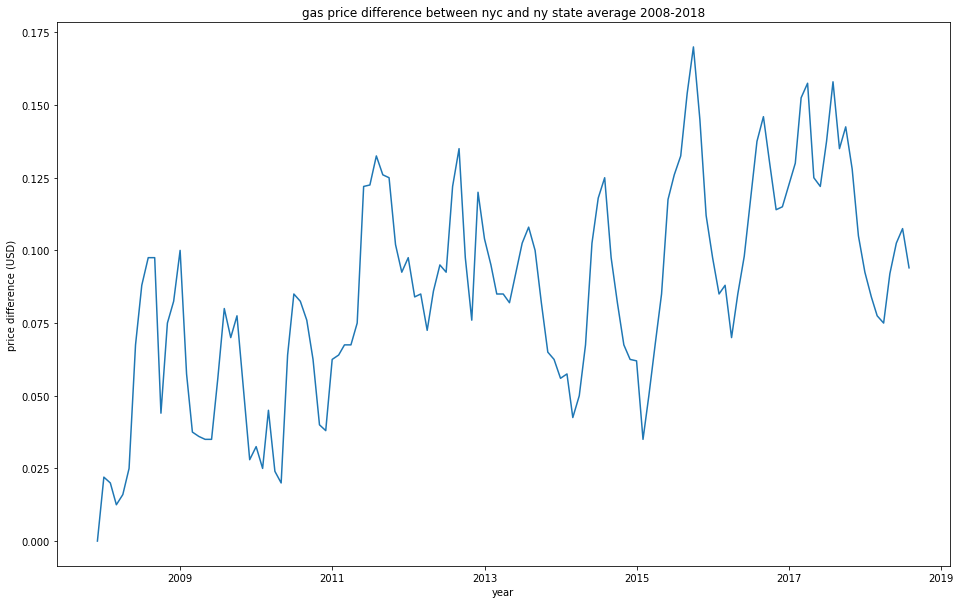

In [12]:
fig, ax = plt.subplots(figsize=[16,10])

ax.plot(filt_gas_data.index, filt_gas_data['nyc'] - filt_gas_data['ny state'])

ax.set(xlabel='year', ylabel='price difference (USD)') 
ax.set_title('gas price difference between nyc and ny state average 2008-2018')
plt.show()

## I then decided to extend this to all counties

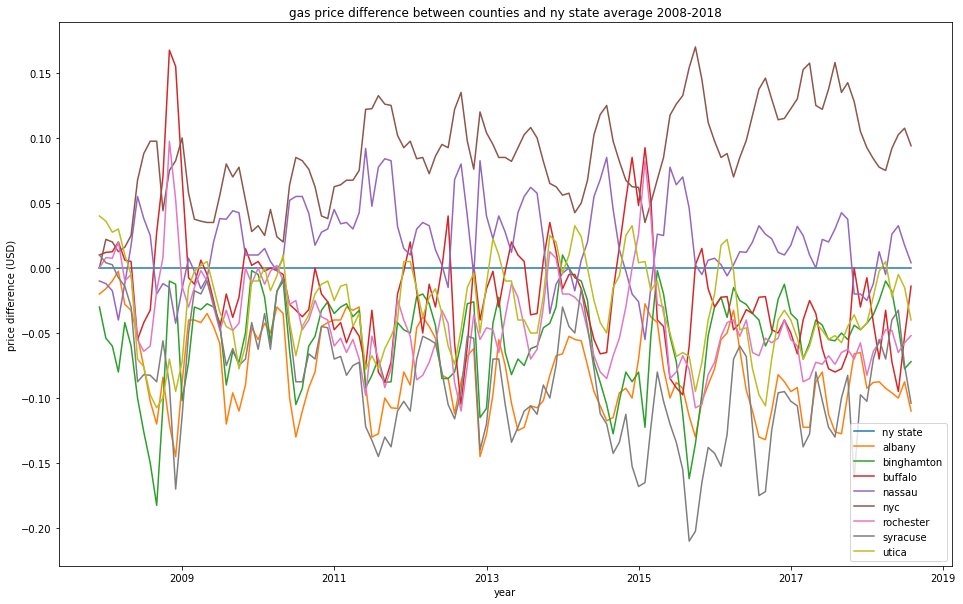

In [13]:
fig, ax = plt.subplots(figsize=[16,10])

for ii in gas_data.columns:
    ax.plot(filt_gas_data.index, filt_gas_data[ii] - filt_gas_data['ny state'], label=str(ii))
    
# ax1 = ax.twinx()
# ax1.plot(filt_sp_data.index, filt_sp_data['Open'] - filt_gas_data['ny state'] , label='s&p open price', linewidth=5.0)

ax.set(xlabel='year', ylabel='price difference (USD)') 
ax.set_title('gas price difference between counties and ny state average 2008-2018')
plt.legend()
plt.show()

## Since analyzing the relation between the counties and against the S&P 500 did not produce anything too interesting, I dediced to take an entirely different approach to analyzing the data and attempt to predict what would happen to gas prices in the coming year.  To do this I used the Facebook Prophet API which takes in a time series and predicts what the data will look like in the future.

In [14]:
m = Prophet()
temp = gas_data.reset_index()
temp = temp.rename(columns={'Date':'ds', 'ny state':'y'})
temp = temp[['ds' ,'y']]
m.fit(temp)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## This first figure shows Prophet's forecast for New York State average gas prices for the 2019 year.  Interestingly, the API decides to plot the raw data, its predicted model, and the noise of the model all on the same graph.  The prediction can be seen on the right side.

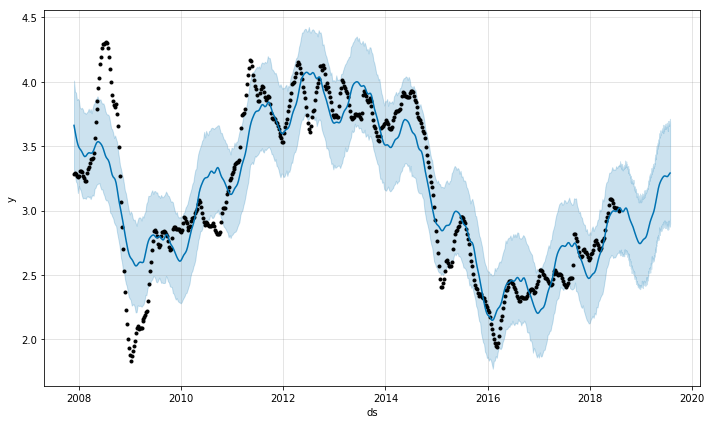

In [15]:
fig1 = m.plot(forecast)

## This second figure shows the component breakdown of the above figure.   The first plot is simply a smoothed trend line and prediction zone. The second plot is a yearly analysis of the gas prices.  This was very interesting to me because it shows that gas prices in New York are almost always less in winter months and greater in summer months.

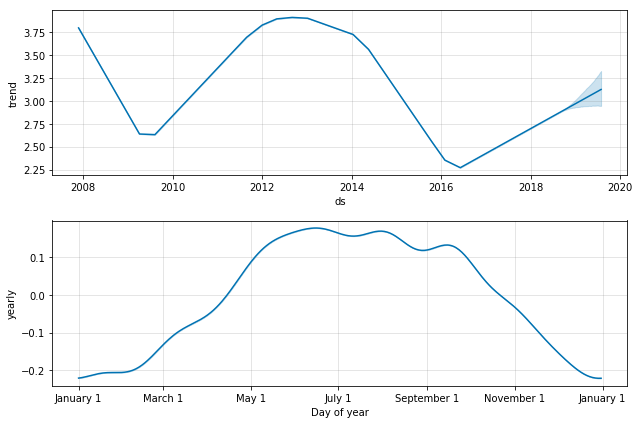

In [16]:
fig2 = m.plot_components(forecast)

## Finally, just for fun, I decided to apply the same Prophet methodology to the S&P 500 data to attempt to predict what the market would look like going forward

In [17]:
m = Prophet()
temp = sp_data.reset_index()
temp = temp.rename(columns={'Date':'ds', 'Open':'y'})
temp = temp[['ds' ,'y']]
m.fit(temp)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Apparently... things are going way up!

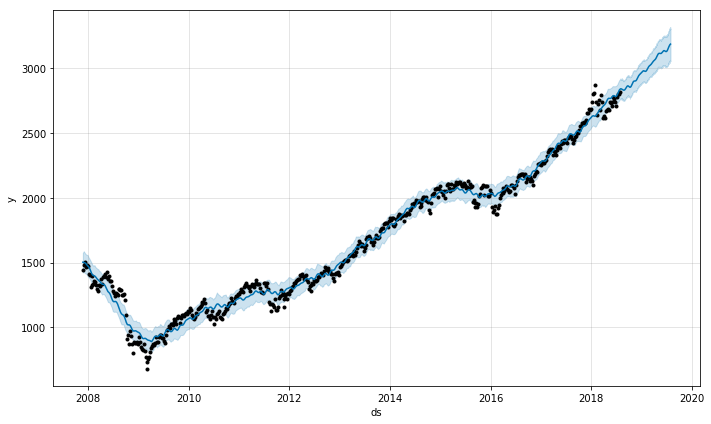

In [18]:
fig1 = m.plot(forecast)

## One final interesting thing I found was that the S&P is seemingly affected by seasonality.  The fall looks to be the lowest season for the market and the spring seems to be the highest.

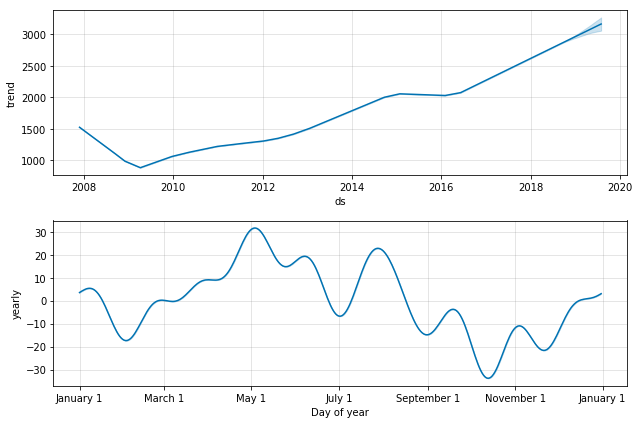

In [19]:
fig2 = m.plot_components(forecast)